# Symbolic Regression with Likelihood-Based Objectives

View at: https://nbviewer.org/github/IsmamHuda/Symbolic-Regression-with-Likelihood-Based-Objectives/blob/main/Symbolics_GLM_Logistic.ipynb

## About
The purpose of this notebook is to demonstrate how Likelihood-based objectives can be used similar to GLMs and other traditional regression techniques, and to encourage users of GLMs to consider Symbolic Regression in some use cases.

## Background
By default, the Symbolic Regression package in Julia uses [Mean Square Error](https://en.wikipedia.org/wiki/Mean_squared_error) as the default objective (as can be seen in [github](https://github.com/MilesCranmer/SymbolicRegression.jl/blob/eafea58565510cca5ed1b8f832ccf27fd233414e/src/Options.jl#L772)) to minimise. Mean Square Error objective is common in regression techniques, including [linear regression via Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares). However, it may not necessarily be suitable or appropriate, espescially if:
- apriori information about the probability distribution of the predicted target ($y$) is known e.g. it is Gamma, or Poisson
- the predicted target has a restricted domain e.g. negative counts, probabilities greater than 1.

#### Traditional GLMs
Traditional [GLMs](https://en.wikipedia.org/wiki/Generalized_linear_model) use likelihood-based objective functions to fit parameters, and selection of predictors:
- A likelihood-based quantity known as [deviance](https://en.wikipedia.org/wiki/Deviance_(statistics)) is used to fit parameter coefficient estimates $\beta_1, \beta_2$ etc...
- Likelihood-based quantities like [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) and [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) are also used as objectives to perform [forward/ backward selection](https://en.wikipedia.org/wiki/Stepwise_regression) to determine which predictors ($x_1, x_2$ etc...) are added/removed to the linear term (η). They combine the log-likelihood with a penalty term to penalise overfitting & model complexity.  

Using likelihood-based objectives in this way results in a fitted model that:
- uses all available apriori information, and hence a more accurate model
- has Maximum Likelihood Estimate parameter estimates.

#### Using Custom Likelihood-Based Objectives With Symbolic Regression
The Symbolic Regression package in Julia allows custom objective functions, and these can be set by the user to be likelihood-based, namely the deviance as used in GLMs. This allows Symbolic Regression to achieve the same benefits of likelihood-based objectives. However, unlike with GLMs, with symbolic regression, we are no longer constrained by the requirement that our predictors be linear, as Symbolic Regression is able to search the space of all feasible functions involving our predictor variables. This allows symbolic regression to naturally discover predictors that have:
- non-linear effects
- interaction effects
- a desired balance of accuracy and simplicity by penalising equation complexity 

Users of GLMs by contrast will need to resort to additional steps to achieve the same goals, and these steps often require lucky guesses about the nature of the non-linearity or interaction to trial and error.

A brillian demonstration of the Symbolic Regression package searching for an equation is available on [Github](https://github.com/MilesCranmer/SymbolicRegression.jl):  
<video src="https://github.com/MilesCranmer/SymbolicRegression.jl/assets/7593028/f5b68f1f-9830-497f-a197-6ae332c94ee0" width="640" height="360" controls></video>  
Credit Miles Cranmer.

# Setup

In [1]:
# Check threads being used. Up to 10 for my M4 MacBook Air.

using Base.Threads
Threads.nthreads()

8

In [2]:
# Set random seed variables for reproducibility
my_seed = 2025;

In [3]:
# load packages
using Pkg, Statistics, Random, Distributions, DataFrames, SymbolicUtils, StatsBase, Plots, PlotlyJS;

using SymbolicRegression: SRRegressor, node_to_symbolic
using MLJ: machine, fit!, predict, report

# Likelihood-based objective functions from GLM and BetaRegression packages
using GLM: devresid,
using BetaRegression: devresid

WebIO._IJuliaInit()

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///Users/ismamhuda/Documents/LocalProjects/SymbolicRegressionWithLikelihoodBasedObjectives/In[3]#9:6\[90mIn[3]:9:6[0;0m]8;;\
using GLM: devresid,
using[48;2;120;70;70m BetaRegression: devresid[0;0m
[90m#    └───────────────────────┘ ── [0;0m[91mextra tokens after end of expression[0;0m

In [4]:
# PlotlyJS backend for Plots, to render interactive 3D
plotlyjs();

# Generate Mock Data
In this step we generate Mock Data, with a predetermined distribution. We will then see if Symbolic Regression is able to recover the equation just using data alone.

$Y|x \sim Bernoulli(p) $ where $ E(Y|x) = p(x) = logistic(x_1x_2^{3.2} + x_1) $

With $0 \le x_1 \le 2$ and $ 0 \le x_2 \le 1 $.

In [5]:
# Define logistic function
logistic(x::T) where {T <: Real} = inv(one(T) + exp(-x));

In [6]:
obs=5000

# Generate random X values
Random.seed!(my_seed)
mockdata = DataFrame(
    x1 = rand(Uniform(0,2), obs),
    x2 = rand(Uniform(0,1), obs)
)

# What is standard deviation as a percent of mean
# Higher value = more noise
std_over_mean = 0.5

# Generate observations from Gamma distribution, with mean a function of the X values, like a GLM
transform!(mockdata, [:x1, :x2] => ((x1, x2) -> logistic.(x1.*(x2.^3.2) + x1)) => :mean)
transform!(mockdata, :mean => ((mean) -> Int64.(rand.(Bernoulli.(mean)))) => :Y_obs)

first(mockdata, 10)

Row,x1,x2,mean,Y_obs
,Float64,Float64,Float64,Int64
1,1.15326,0.00421048,0.760106,1
2,1.6652,0.67699,0.895022,1
3,0.98597,0.445514,0.742717,1
4,1.78637,0.476503,0.875774,0
5,1.74249,0.655261,0.899619,1
6,1.73563,0.924574,0.956314,0
7,1.55002,0.669367,0.878578,1
8,1.21856,0.856682,0.87668,1
9,0.141679,0.266188,0.535871,0


In [7]:
# Subset
X = mockdata[:, [:x1, :x2]];
y = mockdata[:, :Y_obs];

# Visualise Data

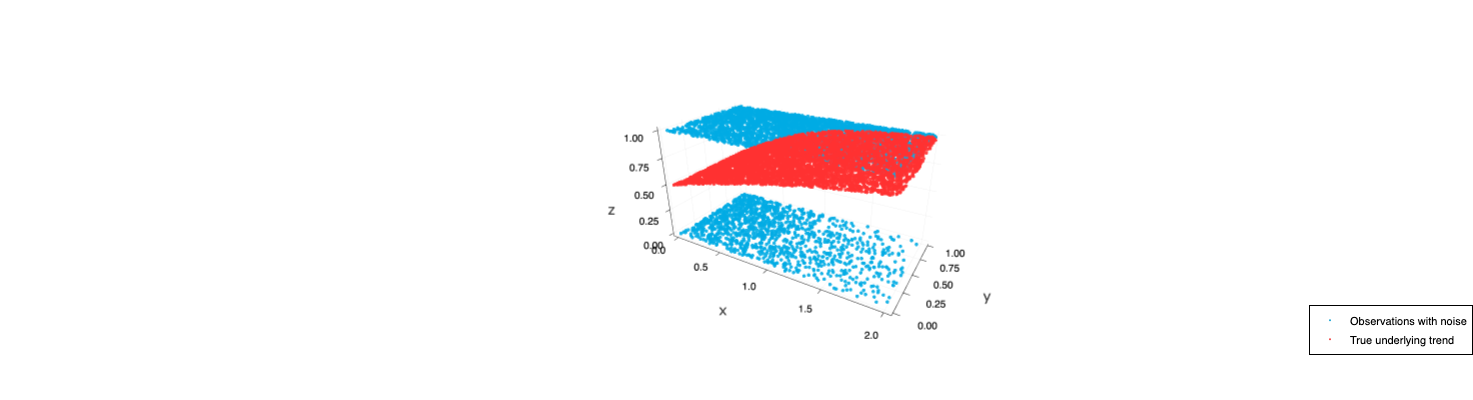

In [8]:
Plots.scatter(
    mockdata.x1,
    mockdata.x2,
    mockdata.Y_obs,
    label = "Observations with noise",
    markerstrokewidth = 0,
    markersize = 1,          # smaller dots
    alpha = 0.9,              # more transparency
    color = :deepskyblue3,      # clearer blue than default
    xlabel = "x1",
    ylabel = "x2",
    zlabel = "Obs / Mean",
    legend = :bottomright
)

Plots.scatter!(
    mockdata.x1,
    mockdata.x2,
    mockdata.mean,
    label = "True underlying trend",
    markerstrokewidth = 0,
    markersize = 1,          # slightly larger for emphasis
    alpha = 0.9,               # solid but not harsh
    color = :firebrick2        # strong red, not neon
)

plot!(
    gridalpha = 0.12,
    camera = (30, 25)
)

# Fit Model With Custom Loss Function

In [9]:
devresid.(Normal(), [10, 5], 3)
# devresid(Normal(), y_obs = 10, true_mean 3)

2-element Vector{Int64}:
 49
  4

In [10]:
devresid.(Bernoulli(), 1, 0.3)

2.4079456086518722

The Best Approach: Relative NLL (Non-Negative and Stable)The recommended solution that satisfies your requirement for a non-negative output while retaining the stability and sensitivity of the log-scale is to use the Relative Negative Log-Likelihood (a form of KL Divergence).$$\text{Loss}_{\text{relative}} = \text{NLL}_{\text{predicted}} - \text{NLL}_{\text{reference}}$$By subtracting the $\text{NLL}$ of a baseline (reference) model, the loss becomes the difference between the model's complexity and the reference.For the Gamma GLM objective you are using: $\text{Loss} = \sum_{i} \left[ \frac{y_i}{\hat{\mu}_i} + \ln(\hat{\mu}_i) \right]$This specific sum has a theoretical minimum value of $N$ (the number of data points) when the prediction exactly matches the data, $\hat{\mu}_i = y_i$.Therefore, the most stable, non-negative loss function that mimics the GLM objective is:$$\text{Loss}_{\text{Non-Negative}} = \sum_{i=1}^N \left[ \frac{y_i}{\hat{\mu}_i} + \ln(\hat{\mu}_i) - 1 \right]$$

In [17]:
methods(devresid)

# 10 methods for generic function "devresid" from GLM:
  [1] devresid(::Geometric, y, μ::Real)
     @ ~/.julia/packages/GLM/vM20T/src/glmtools.jl:471
  [2] devresid(b::BetaRegression.BetaRegressionModel)
     @ ~/.julia/packages/BetaRegression/7bGHD/src/BetaRegression.jl:373
  [3] devresid(::Poisson, y, μ::Real)
     @ ~/.julia/packages/GLM/vM20T/src/glmtools.jl:482
  [4] devresid(::Gamma, y, μ::Real)
     @ ~/.julia/packages/GLM/vM20T/src/glmtools.jl:470
  [5] devresid(::Normal, y, μ::Real)
     @ ~/.julia/packages/GLM/vM20T/src/glmtools.jl:481
  [6] devresid(::InverseGaussian, y, μ::Real)
     @ ~/.julia/packages/GLM/vM20T/src/glmtools.jl:475
  [7] devresid(a::StatsModels.TableRegressionModel{<:BetaRegression.BetaRegressionModel}, args...; kwargs...)
     @ ~/.julia/packages/StatsModels/5Gq5O/src/statsmodel.jl:28
  [8] devresid(::Binomial, y, μ::Real)
     @ ~/.julia/packages/GLM/vM20T/src/glmtools.jl:461
  [9] devresid(d::NegativeBinomial, y, μ::Real)
     @ ~/.julia/packages/GLM/vM20T/src/glmtools.jl:476
 [10] devresid(::Bernoulli, y, μ::Real)
     @ ~/.julia/packages/GLM/vM20T/src/glmtools.jl:453

In [12]:
using GLM: devresid 
# Import the function object from GLM to enable use below
# You will also need to have loaded GLM and any other package needed.

"""
    make_glm_devresid_objective(D)

Returns a custom loss function (closure) that calculates the total deviance
for a specific GLM family D.
"""
function make_glm_devresid_objective(D)
    
    # This is the inner function that SRRegressor calls:
    function custom_likelihood_based_obj(tree, dataset, options)

        μ_pred, flag = eval_tree_array(tree, dataset.X, options)
        
        # 1. Handle evaluation errors and domain constraints
        # Ensure predicted mean is within the bounds of the distribution D
        if !flag || any(μ_pred .<= 0)
            return Inf
        end
        
        y_true = dataset.y
        
        # 2. CRITICAL LOGIC FIX: Deviance = SUM(devresid^2)
        # devresid order: devresid(Family, y, μ)
        # Use abs2() to square the residual and sum() to get total Deviance
        # This is the standard GLM objective.
        total_deviance = sum(
            abs2.(devresid.(D, y_true, μ_pred))
        )
        
        # Ensure the loss is a non-negative scalar
        return total_deviance
    end
    
    # Return the inner function (the closure)
    return custom_likelihood_based_obj
end

make_glm_devresid_objective

In [72]:
model = SRRegressor(
    binary_operators=[+,*,-,/,^],
    unary_operators=[abs, inv, log, exp, sin, cos, tan],
    niterations=50,
    should_simplify = true,
    should_optimize_constants = true,
    print_precision=2,
    seed=my_seed,
    # turbo = true,
    save_to_file = false,
    loss_function=make_glm_devresid_objective(Normal()),
    progress = false);

In [68]:
using LoopVectorization

In [69]:
using SymbolicRegression: eval_tree_array

In [70]:
mockdata

Row,x1,x2,mean,Y_obs
,Float64,Float64,Float64,Int64
1,1.15326,0.00421048,0.760106,1
2,1.6652,0.67699,0.895022,1
3,0.98597,0.445514,0.742717,1
4,1.78637,0.476503,0.875774,0
5,1.74249,0.655261,0.899619,1
6,1.73563,0.924574,0.956314,0
7,1.55002,0.669367,0.878578,1
8,1.21856,0.856682,0.87668,1
9,0.141679,0.266188,0.535871,0


In [ ]:
# Train model
mach = machine(model, X, y)
fit!(mach)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc SymbolicRegression.SRRegressor` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}, AbstractVector{ScientificTypesBase.Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{ScientificTypesBase.Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Scientif


Expressions evaluated per second: 2.110e+04
Progress: 120 / 1550 total iterations (7.742%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.605e+02  0.000e+00  y = 0.59
5           2.444e+02  1.588e-02  y = cos(cos(x1 / 3))
7           2.434e+02  2.131e-03  y = sin(abs(cos(exp(x1 * -0.14))))
8           2.426e+02  3.391e-03  y = sin(cos(cos(x1 / exp(cos(x2)))))
10          2.421e+02  9.207e-04  y = sin(cos(cos(x1 / exp(cos(x2 ^ x1)))))
12          2.419e+02  5.383e-04  y = sin(cos(cos(x1 / exp(cos((x2 ^ x1) ^ 0.72)))))
14          2.414e+02  1.021e-03  y = sin(cos(cos(x1 / exp(cos(cos(x1 / exp(x2 ^ x1)))))))
16          2.413e+02  6.676e-05  y = sin(cos(cos(x1 / exp(cos(cos(x1 / exp((x2 / 0.96) ^ x1...
                                      )))))))
27          2.413e+02  7.473e-06

In [21]:
# Organise results into dictionary
report_mach = report(mach);
report_dict = Dict(pairs(report_mach));
delete!(report_dict, :best_idx);
# delete!(report_dict, :equations);

# Organise into dataframe for easy inspection
report_df = DataFrame(report_dict)
report_df[!, :score_rank] = competerank(-report_df.scores)
report_df

# Best result (tradeoff between simplicity and fit) has score_rank=1

Row,complexities,equation_strings,equations,losses,scores,score_rank
,Int64,String,Expressi…,Float64,Float64,Int64
1,1,1.267236325036355e6,1.267236325036355e6,7026.17,0.0,19
2,3,x2 * 56064.96211394407,x2 * 56064.96211394407,6730.77,0.0214767,2
3,5,x1 * (x2 ^ 3.1958604486519606),x1 * (x2 ^ 3.1958604486519606),6335.18,0.0302853,1
4,7,(x2 + (x2 ^ 3.1926990232236485)) * x1,(x2 + (x2 ^ 3.1926990232236485)) * x1,6333.81,0.00010827,3
5,9,x1 * (((x2 ^ 3.14378543033349) + 0.6514696022137297) * 1.1513567360806833),x1 * (((x2 ^ 3.14378543033349) + 0.6514696022137297) * 1.1513567360806833),6333.69,9.51035e-6,7
6,11,(x1 * ((x2 ^ 3.143892967552028) * 1.151004240348511)) + (x1 - 22.55712682147441),(x1 * ((x2 ^ 3.143892967552028) * 1.151004240348511)) + (x1 - 22.55712682147441),6333.69,1.50392e-7,15
7,12,x1 + ((((x2 ^ 3.153003589849246) * x1) - tan(x1)) * 1.1217149459992826),x1 + ((((x2 ^ 3.153003589849246) * x1) - tan(x1)) * 1.1217149459992826),6333.65,5.45634e-6,11
8,13,x1 + ((tan(log(x1)) + ((x2 ^ 3.155451752172882) * x1)) * 1.1139318572657206),x1 + ((tan(log(x1)) + ((x2 ^ 3.155451752172882) * x1)) * 1.1139318572657206),6333.53,1.99131e-5,6
9,14,x1 + (((x1 * (x2 ^ 3.145467086567554)) - tan(x2 ^ 1.526804701451731)) * 1.1457071014477678),x1 + (((x1 * (x2 ^ 3.145467086567554)) - tan(x2 ^ 1.526804701451731)) * 1.1457071014477678),6332.95,9.04063e-5,4


In [22]:
# Identify best expression

best_expression = report_mach[2][report_mach[1]]
best_expression_eqn = node_to_symbolic(best_expression)
best_expression_eqn_simp = simplify(best_expression_eqn)
best_expression_eqn_simp

x1 * (x2 ^ 3.1958604486519606)